In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [76]:
ecg_dataset = pd.read_csv('ecg.csv', header=None)
microsoft_stocks_dataset = pd.read_csv('Microsoft_Stock.csv')
month_value_dataset = pd.read_csv('Month_Value_1.csv')
yahoo_stocks_dataset = pd.read_csv('yahoo_stock.csv')

ecg_columns = [f'ECG_{i+1}' for i in range(140)]
ecg_dataset.columns = ecg_columns + ['label']

yahoo_stocks_dataset['Date'] = pd.to_datetime(yahoo_stocks_dataset['Date'])

In [77]:
month_value_dataset.columns

Index(['Period', 'Revenue', 'Sales_quantity', 'Average_cost',
       'The_average_annual_payroll_of_the_region'],
      dtype='object')

<Axes: >

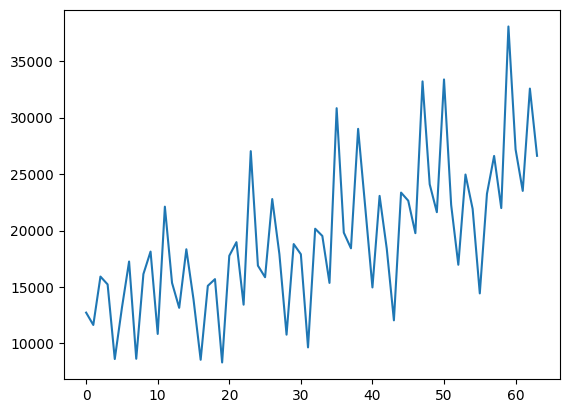

In [78]:
month_value_dataset['Sales_quantity'].plot()

In [79]:
microsoft_stocks_dataset.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

<Axes: >

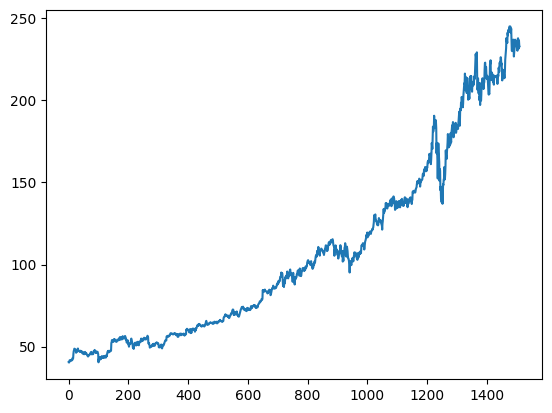

In [80]:
microsoft_stocks_dataset['Open'].plot()

<Axes: >

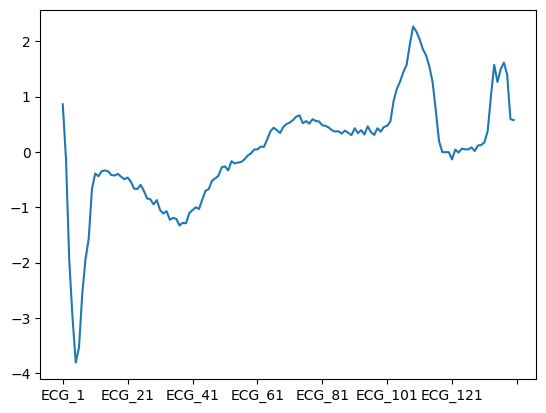

In [81]:
ecg_dataset.loc[40, ecg_columns].plot()

In [82]:
yahoo_stocks_dataset.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

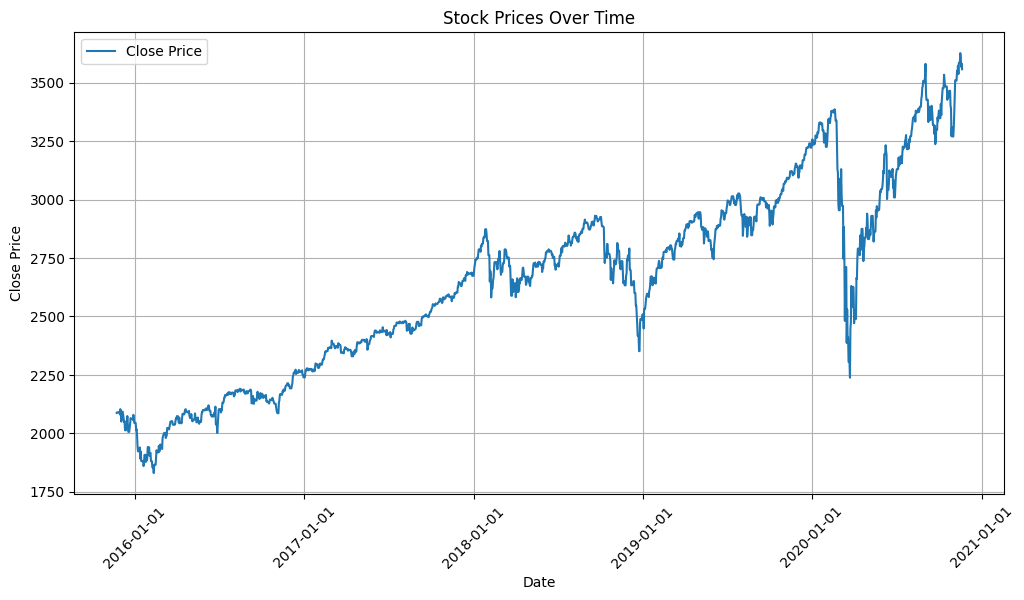

In [85]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(yahoo_stocks_dataset['Date'], yahoo_stocks_dataset['Close'], label="Close Price")

# Format the x-axis to show some dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically chooses a good interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD

# Rotate dates for better visibility
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)

# Show plot
plt.show()